In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adam

from pathlib import Path
import os.path

from sklearn.metrics import classification_report, confusion_matrix


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def seed_everything(seed=42):

    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )

    tf.compat.v1.set_random_seed(seed)

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

seed_everything()


In [4]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot


--2024-06-07 10:54:52--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-06-07 10:54:52 (93.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [5]:
dataset = "/content/drive/MyDrive/coraImages_reduz"
walk_through_dir(dataset)


There are 2 directories and 0 images in '/content/drive/MyDrive/coraImages_reduz'.
There are 0 directories and 247 images in '/content/drive/MyDrive/coraImages_reduz/bleached_corals'.
There are 0 directories and 249 images in '/content/drive/MyDrive/coraImages_reduz/healthy_corals'.


In [6]:
def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(dataset)


In [7]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(dataset).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)


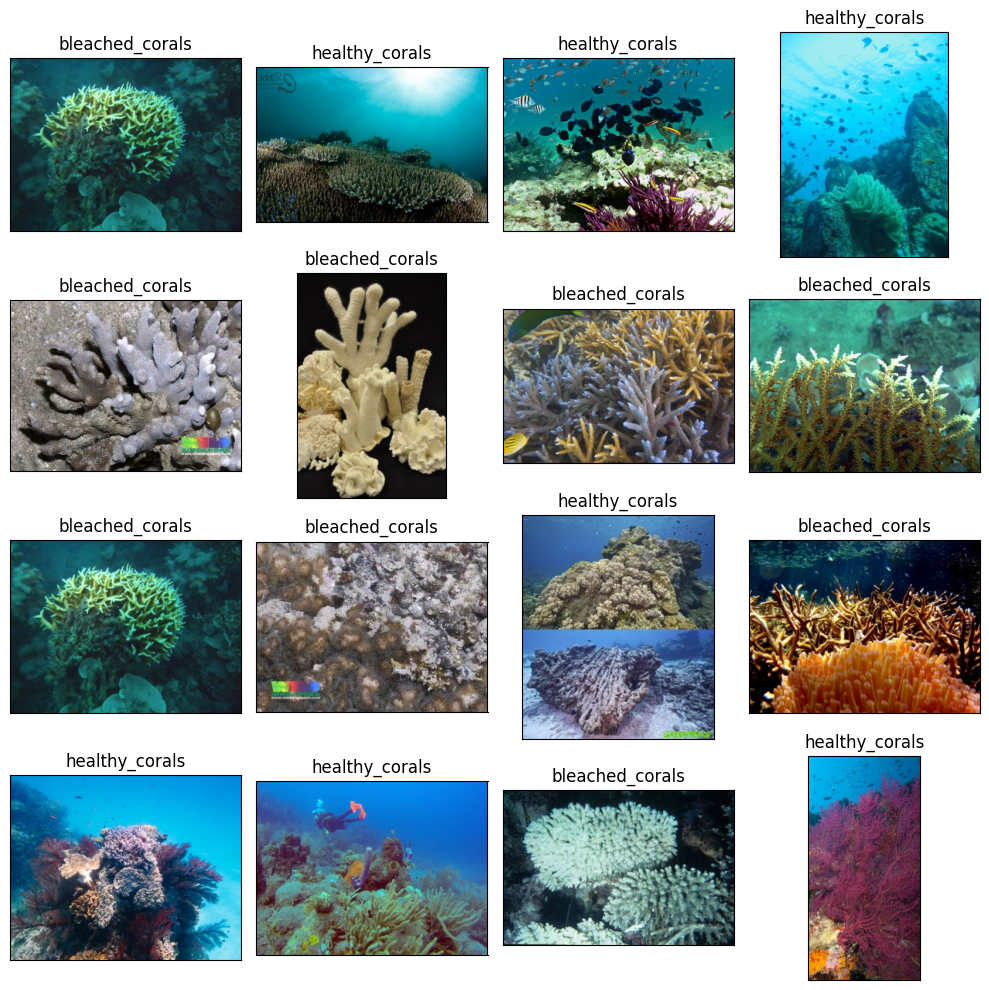

In [8]:
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()


In [9]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)


In [10]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)


In [11]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)


In [12]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 317 validated image filenames belonging to 2 classes.
Found 79 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.


In [13]:
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])


In [14]:
pretrained_model = tf.keras.applications.vgg19.VGG19(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False


80134624/80134624 [==============================] - 5s 0us/step


In [15]:
checkpoint_path = "corals_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 5,
                               restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-10)


In [30]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)


outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=30,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "corals_classification"),
        checkpoint_callback,
        reduce_lr
    ]
)


Saving TensorBoard log files to: training_logs/corals_classification/20240607-111443
Epoch 1/30
10/10 [==============================] - 7s 341ms/step - loss: 1.1397 - accuracy: 0.5331 - val_loss: 2.0378 - val_accuracy: 0.6329 - lr: 0.0010
Epoch 2/30
10/10 [==============================] - 3s 300ms/step - loss: 0.8065 - accuracy: 0.7287 - val_loss: 2.0934 - val_accuracy: 0.5949 - lr: 0.0010
Epoch 3/30
10/10 [==============================] - 4s 374ms/step - loss: 0.5603 - accuracy: 0.7634 - val_loss: 1.8853 - val_accuracy: 0.5696 - lr: 0.0010
Epoch 4/30
10/10 [==============================] - 4s 383ms/step - loss: 0.5239 - accuracy: 0.7950 - val_loss: 1.3285 - val_accuracy: 0.6456 - lr: 0.0010
Epoch 5/30
10/10 [==============================] - 3s 315ms/step - loss: 0.4296 - accuracy: 0.8076 - val_loss: 1.1532 - val_accuracy: 0.6709 - lr: 0.0010
Epoch 6/30
10/10 [==============================] - 3s 300ms/step - loss: 0.3805 - accuracy: 0.8202 - val_loss: 1.1224 - val_accuracy: 0.683

In [31]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))


    Test Loss: 0.66962
Test Accuracy: 77.00%


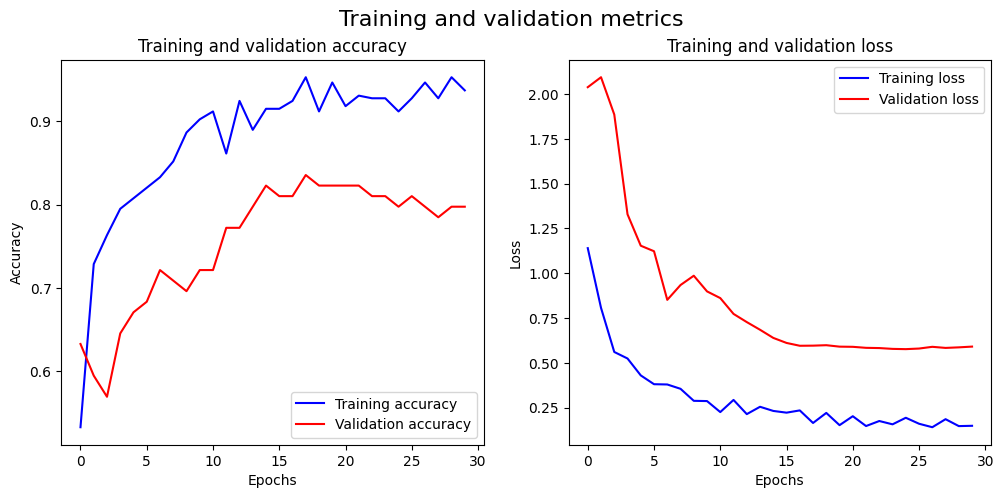

In [32]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(epochs, accuracy, 'b', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(epochs, loss, 'b', label='Training loss')
ax2.plot(epochs, val_loss, 'r', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

fig.suptitle('Training and validation metrics', fontsize=16)
plt.show()


In [33]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)


labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]


print(f'The first 5 predictions: {pred[:5]}')


4/4 [==============================] - 1s 186ms/step
The first 5 predictions: ['healthy_corals', 'healthy_corals', 'healthy_corals', 'bleached_corals', 'healthy_corals']


In [ ]:
model.save("coral.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [35]:
nova_imagem = cv2.imread('/content/drive/MyDrive/imagensCorais/coralbranco.jpg')
nova_imagem = cv2.resize(nova_imagem, (224, 224))
nova_imagem = nova_imagem / 255.0


nova_imagem = np.expand_dims(nova_imagem, axis=0)


previsoes = model.predict(nova_imagem)


labels = train_images.class_indices


labels = {v: k for k, v in labels.items()}


rotulo_previsto = labels[np.argmax(previsoes)]

print(f'O rótulo previsto para a nova imagem é: {rotulo_previsto}')


1/1 [==============================] - 0s 24ms/step
O rótulo previsto para a nova imagem é: bleached_corals
